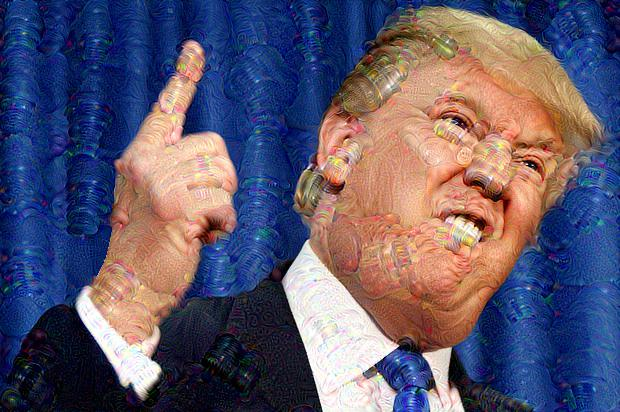

In [11]:
import os
from io import BytesIO
import numpy as np
import PIL.Image
from IPython.display import clear_output, Image, display  # , HTML

# version 2.X
import tensorflow as tf2
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

directory = os.getcwd() + '//'
model_fn = directory + 'tensorflow_inception_graph.pb'

# creating TensorFlow session and loading the model
graph = tf.Graph()
sess = tf.InteractiveSession(graph=graph)
with tf.gfile.FastGFile(model_fn, 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())

layers = [op.name for op in graph.get_operations() if op.type == 'Conv2D' and 'import/' in op.name]
feature_nums = [int(graph.get_tensor_by_name(name + ':0').get_shape()[-1]) for name in layers]

# print(layers[-10:])
# print('Number of layers', len(layers))
# print('Total number of feature channels:', sum(feature_nums))

t_input = tf.placeholder(np.float32, name='input')  # define the input tensor
# imagenet_mean = 117.0
t_preprocessed = tf.expand_dims(t_input - 117.0, 0)
tf.import_graph_def(graph_def, {'input': t_preprocessed})

# The default image: a random image with a little noise
img_noise = np.random.uniform(size=(224, 224, 3)) + 100.0


def show_img(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 1) * 255)
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    gen_img = Image(data=f.getvalue())
    display(gen_img)


def visstd(a, s=0.1):
    '''Normalize the image range for visualization'''
    return (a - a.mean()) / max(a.std(), 1e-4) * s + 0.5


def T(layer):
    '''Helper for getting layer output tensor'''
    # for op in tf.get_default_graph().get_operations():
    #   print(str(op.name))

    return graph.get_tensor_by_name("import/%s:0" % layer)


def calc_grad_tiled(img, t_grad, tile_size=512):
    '''Compute the value of tensor t_grad over the image in a tiled way.
    Random shifts are applied to the image to blur tile boundaries over
    multiple iterations.'''
    sz = tile_size
    h, w = img.shape[:2]
    sx, sy = np.random.randint(sz, size=2)
    img_shift = np.roll(np.roll(img, sx, 1), sy, 0)
    grad = np.zeros_like(img)
    for y in range(0, max(h - sz // 2, sz), sz):
        for x in range(0, max(w - sz // 2, sz), sz):
            sub = img_shift[y:y + sz, x:x + sz]
            g = sess.run(t_grad, {t_input: sub})
            grad[y:y + sz, x:x + sz] = g
    return np.roll(np.roll(grad, -sx, 1), -sy, 0)


def render_deepdream(t_obj, img0=img_noise,
                     iter_n=10, step=1.5, pic_n=5):
    t_score = tf.reduce_mean(t_obj)  # defining the optimization objective
    t_grad = tf.gradients(t_score, t_input)[0]  # behold the power of automatic differentiation!

    img = img0
    for pic in range(pic_n):
        for i in range(iter_n):
            g = calc_grad_tiled(img, t_grad)
            img += g * (step / (np.abs(g).mean() + 1e-7))
            print('.', end=' ')
        clear_output()
        show_img(img / 255.0)


# img = PIL.Image.open(directory + 'hawkeye.jpg')
# img = PIL.Image.open(directory + 'pitt.jpg')
img = PIL.Image.open(directory + 'trump.jpg')
img = np.float32(img)
show_img(img / 255.0)

# Picking some internal layer. Note that we use outputs before applying the ReLU nonlinearity
# to have non-zero gradients for features with negative initial activations.
# layer = 'mixed4d_3x3_bottleneck_pre_relu'
layer = 'mixed5a_3x3_bottleneck_pre_relu'
# render_deepdream(T(layer)[:,:,:,139], img) # 139 is the channel number
render_deepdream(T(layer)[:, :, :, 90], img)  # 99 is the channel number
# render_deepdream(tf.square(T('mixed4c')), img)
tf.InteractiveSession.close(sess)